In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
#import imageio, skimage

import torch

from collections import Counter

## Example from VirTex

code from `arch-pre-training/virtex/data/datasets/coco_captions.py`

In [2]:
# code from virtex/data/datasets/coco_captions.py

from collections import defaultdict
import json
import os
from typing import Dict, List

import cv2
from torch.utils.data import Dataset

In [3]:
USE_CUSTOM = True

if not USE_CUSTOM:
    from virtex.data.datasets.coco_captions import CocoCaptionsDataset
else:
    class CocoCaptionsDataset(Dataset):
        r"""
        A PyTorch dataset to read COCO Captions dataset and provide it completely
        unprocessed. This dataset is used by various task-specific datasets
        in :mod:`~virtex.data.datasets` module.

        Args:
            data_root: Path to the COCO dataset root directory.
            split: Name of COCO 2017 split to read. One of ``{"train", "val"}``.
        """

        def __init__(self, data_root: str, split: str):

            # Get paths to image directory and annotation file.
            image_dir = os.path.join(data_root, f"{split}2017")
            captions = json.load(
                open(os.path.join(data_root, "annotations", f"captions_{split}2017.json"))
            )
            # Collect list of captions for each image.
            captions_per_image: Dict[int, List[str]] = defaultdict(list)
            for ann in captions["annotations"]:
                captions_per_image[ann["image_id"]].append(ann["caption"])

            # Collect image file for each image (by its ID).
            image_filepaths: Dict[int, str] = {
                im["id"]: os.path.join(image_dir, im["file_name"])
                for im in captions["images"]
            }
            # Keep all annotations in memory. Make a list of tuples, each tuple
            # is ``(image_id, file_path, list[captions])``.
            self.instances = [
                (im_id, image_filepaths[im_id], captions_per_image[im_id])
                for im_id in captions_per_image.keys()
            ]

        def __len__(self):
            return len(self.instances)

        def __getitem__(self, idx: int):
            image_id, image_path, captions = self.instances[idx]

            # shape: (height, width, channels), dtype: uint8
            try:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except Exception as e:
                print(e)

            return {"image_id": image_id, "image": image, "captions": captions}

Check how the dataset object behaves

In [4]:
coco_dataset = CocoCaptionsDataset('../datasets/coco', split='train')

In [5]:
coco_dataset.instances

[(203564,
  '../datasets/coco/train2017/000000203564.jpg',
  ['A bicycle replica with a clock as the front wheel.',
   'The bike has a clock as a tire.',
   'A black metal bicycle with a clock inside the front wheel.',
   'A bicycle figurine in which the front wheel is replaced with a clock\n',
   'A clock with the appearance of the wheel of a bicycle ']),
 (322141,
  '../datasets/coco/train2017/000000322141.jpg',
  ['A room with blue walls and a white sink and door.',
   'Blue and white color scheme in a small bathroom.',
   'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
   'A blue boat themed bathroom with a life preserver on the wall',
   'A bathroom with walls that are painted baby blue.']),
 (16977,
  '../datasets/coco/train2017/000000016977.jpg',
  ['A car that seems to be parked illegally behind a legally parked car',
   'two cars parked on the sidewalk on the street',
   'City street with parked cars and a bench.',
   'Cars try to maneuver in

In [6]:
coco_dataset.__getitem__(0)

OpenCV(4.5.3) /Users/runner/miniforge3/conda-bld/libopencv_1633800949369/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



{'image_id': 203564,
 'image': None,
 'captions': ['A bicycle replica with a clock as the front wheel.',
  'The bike has a clock as a tire.',
  'A black metal bicycle with a clock inside the front wheel.',
  'A bicycle figurine in which the front wheel is replaced with a clock\n',
  'A clock with the appearance of the wheel of a bicycle ']}

## PubMed Dataset

In [7]:
pubmed_set_dir = '../datasets/ARCH/pubmed_set'

In [8]:
os.listdir(pubmed_set_dir)

['.DS_Store', 'images', 'captions.json', 'README.md']

In [9]:
os.listdir(pubmed_set_dir +'/images')[:5]

['a97abc1d-58ae-4a90-965d-ecb7fd353c7a.jpg',
 'bfce72df-d774-4641-b1f9-7849efa080ad.jpg',
 '96999c16-8506-40b8-9d82-4e6dc7bcf34b.jpg',
 '6f81441b-16b8-47d0-9c01-5a0de58638bc.jpg',
 'a7044061-47f5-4eb2-9264-64bd87f3194d.jpg']

**Not all images in the PubMed dataset are in .jpg format. There are 37 png images.**

In [10]:
with open(f'{pubmed_set_dir}/captions.json', 'r') as f:
    pubmed_captions = json.load(f)

In [11]:
pubmed_captions

{'0': {'caption': 'ER expression in tumor tissue. IHC staining, original',
  'uuid': '3f93c716-8fc9-42e9-bc29-bec52a51ab4b'},
 '1': {'caption': 'Nuclear expression of TS (brown) in a colon carcinoma',
  'uuid': '9fcdf1e1-139c-4b63-bf1a-79d83c71f41a'},
 '2': {'caption': 'Nuclear expression of E2F1 (brown) in a colon carcinoma. This is higher magnification of the upper portion of a core shown in an inset (lower left corner)',
  'uuid': '00f1ad7a-f4b0-4938-b874-089d40a123ce'},
 '3': {'caption': 'Cytoplasmic immunoexpression of PD-L1 in oral squamous cell carcinomas with poorer prognosis (OSCCPP). Immunohistochemistry. Total magnification x100',
  'uuid': '9d3aef30-7c8b-4b78-9acf-ec523f952650'},
 '4': {'caption': 'Nuclear and perinuclear immunoexpression of Foxp3 in oral squamous cell carcinomas with poorer prognosis (OSCCPP). Immunohistochemistry. Total magnification x100',
  'uuid': 'b317d529-3626-49fc-9282-e4f28cf3d1cb'},
 '5': {'caption': 'Cytoplasmic immunoexpression of PD-L1 in oral 

Indices appear to be integers from 0 to 3308.

In [12]:
# Check for duplicates (slightly pointless since keys have to be unique anyway)
assert len(pubmed_captions.keys()) == len(set(pubmed_captions.keys()))

# check for the indices to be without gaps ['0', '1', '2', ..., '3308']
assert sorted(list(pubmed_captions.keys())) == sorted([str(i) for i in range(len(pubmed_captions.keys()))])

A simple check confirms that everything is in order.

In [13]:
## Old version

# class ArchPubmedCaptionsDataset(Dataset):
#     r"""
#     A PyTorch dataset to read ARCH Pubmed dataset and provide it completely
#     unprocessed. This dataset is used by various task-specific datasets
#     in :mod:`~virtex.data.datasets` module.

#     Args:
#         data_root: Path to the ARCH dataset root directory.
#         split: Name of ARCH split to read. One of ``{"train", "val"}``.
#     """

#     def __init__(self, data_root: str, split: str=''):

# #         TODO: change after splitting the caption files into train and validation
# #         
# #         # Get paths to image directory and annotation file.
# #         image_dir = os.path.join(data_root, "pubmed_set/images", f"{split}")
# #         captions = json.load(
# #             open(os.path.join(data_root, "pubmed_set", f"captions_{split}.json"))
# #         )
        
#         # Get paths to image directory and annotation file.
#         image_dir = os.path.join(data_root, "pubmed_set/images")
#         captions = json.load(
#             open(os.path.join(data_root, "pubmed_set", "captions.json"))
#         )
        
#         # Collect list of captions for each image.
#         captions_per_image: Dict[int, List[str]] = defaultdict(list)
#         for idx, ann in captions.items():
#             captions_per_image[ann['uuid']].append(ann['caption'])
#         #print(captions_per_image)

#         # Collect image file for each image (by its ID).
#         image_filepaths: Dict[int, str] = {
#             ann["uuid"]: os.path.join(image_dir, f"{ann['uuid']}.jpg")
#             for idx, ann in captions.items()
#         }
#         # Keep all annotations in memory. Make a list of tuples, each tuple
#         # is ``(image_id, file_path, list[captions])``.
#         self.instances = [
#             (im_id, image_filepaths[im_id], captions_per_image[im_id])
#             for im_id in captions_per_image.keys()
#         ]

#     def __len__(self):
#         return len(self.instances)

#     def __getitem__(self, idx: int):
#         image_id, image_path, captions = self.instances[idx]

#         # shape: (height, width, channels), dtype: uint8
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2.imread loads images in BGR (blue, green, red) order

#         return {"image_id": image_id, "image": image, "captions": captions}
    
    
# # test
# arch_pubmed_dataset = ArchPubmedCaptionsDataset('../datasets/ARCH')
# arch_pubmed_dataset.instances

# test_instance = arch_pubmed_dataset.__getitem__(0)

# print(test_instance['image_id'])
# print(test_instance['image'].shape)


# plt.imshow(test_instance['image'])

In [14]:
class ArchPubmedCaptionsDataset(Dataset):
    r"""
    A PyTorch dataset to read ARCH Pubmed dataset and provide it completely
    unprocessed. This dataset is used by various task-specific datasets
    in :mod:`~virtex.data.datasets` module.

    Args:
        data_root: Path to the ARCH dataset root directory.
        split: Name of ARCH split to read. One of ``{"train", "val"}``.
    """

    def __init__(self, data_root: str, split: str=''):

#         TODO: change after splitting the caption files into train and validation
#         
#         # Get paths to image directory and annotation file.
#         image_dir = os.path.join(data_root, "pubmed_set/images", f"{split}")
#         captions = json.load(
#             open(os.path.join(data_root, "pubmed_set", f"captions_{split}.json"))
#         )
        
        # Get path to image directory and record the extensions
        image_dir = os.path.join(data_root, "pubmed_set/images")
        uuids_to_extensions = {
            file_name.split('.')[0]: file_name.split('.')[1]
            for file_name in os.listdir(image_dir)
        }
        
        # Get path to the annotation file
        captions = json.load(
            open(os.path.join(data_root, "pubmed_set", "captions.json"))
        )
        
        # Collect list of uuids and file paths for each caption
        captions_to_uuids: Dict[str, List[str]] = defaultdict(list)
        captions_to_image_filepaths: Dict[str, List[str]] = defaultdict(list)
        for idx, ann in captions.items():
            if ann['uuid'] in uuids_to_extensions.keys():
                # uuids_to_extensions contains only image uuids from the image dir
                # this means that only uuids with exisitng images will be added
                captions_to_uuids[ann['caption']].append(ann['uuid'])
                captions_to_image_filepaths[ann['caption']].append(
                    os.path.join(image_dir, f"{ann['uuid']}.{uuids_to_extensions[ann['uuid']]}")
                )
        #print(captions_per_image)

        # Keep all annotations in memory. Make a list of tuples, each tuple
        # is ``(list[image_id], list[file_path], captions)``.
        self.instances = [
            (captions_to_uuids[caption], captions_to_image_filepaths[caption], caption)
            for caption in captions_to_image_filepaths.keys()
        ]

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx: int):
        image_ids, image_paths, caption = self.instances[idx]

        # shape: (height, width, channels), dtype: uint8
        images = [cv2.imread(image_path) for image_path in image_paths]
        # cv2.imread loads images in BGR (blue, green, red) order
        images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

        return {"image_ids": image_ids, "images": images, "caption": caption}

In [15]:
arch_pubmed_dataset = ArchPubmedCaptionsDataset('../datasets/ARCH')
arch_pubmed_dataset.instances

[(['3f93c716-8fc9-42e9-bc29-bec52a51ab4b'],
  ['../datasets/ARCH/pubmed_set/images/3f93c716-8fc9-42e9-bc29-bec52a51ab4b.jpg'],
  'ER expression in tumor tissue. IHC staining, original'),
 (['9fcdf1e1-139c-4b63-bf1a-79d83c71f41a'],
  ['../datasets/ARCH/pubmed_set/images/9fcdf1e1-139c-4b63-bf1a-79d83c71f41a.jpg'],
  'Nuclear expression of TS (brown) in a colon carcinoma'),
 (['00f1ad7a-f4b0-4938-b874-089d40a123ce'],
  ['../datasets/ARCH/pubmed_set/images/00f1ad7a-f4b0-4938-b874-089d40a123ce.jpg'],
  'Nuclear expression of E2F1 (brown) in a colon carcinoma. This is higher magnification of the upper portion of a core shown in an inset (lower left corner)'),
 (['9d3aef30-7c8b-4b78-9acf-ec523f952650'],
  ['../datasets/ARCH/pubmed_set/images/9d3aef30-7c8b-4b78-9acf-ec523f952650.jpg'],
  'Cytoplasmic immunoexpression of PD-L1 in oral squamous cell carcinomas with poorer prognosis (OSCCPP). Immunohistochemistry. Total magnification x100'),
 (['b317d529-3626-49fc-9282-e4f28cf3d1cb'],
  ['../data

ER expression in tumor tissue. IHC staining, original 

Total images: 1 

3f93c716-8fc9-42e9-bc29-bec52a51ab4b


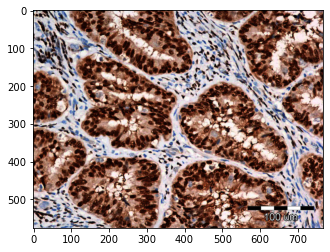

In [16]:
test_instance = arch_pubmed_dataset.__getitem__(0)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

Low-grade peritoneal serous carcinoma. Monomorphic cells associated with psammoma bodies are seen. Hematoxylin and eosin stain, original magnification: x100. 

Total images: 3 

8764ba9f-d248-4d12-b9dd-4d8d6a28a9de


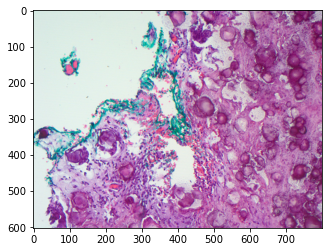

fb650184-e406-4fc5-9a41-c8940c05d6a7


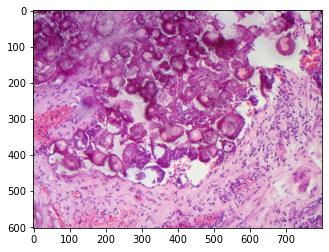

2b9426a9-f26c-436e-8b41-da3bdf1b6fe1


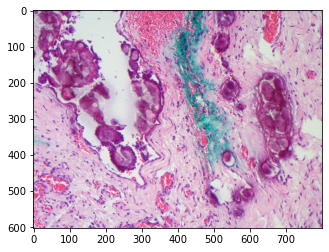

In [17]:
test_instance = arch_pubmed_dataset.__getitem__(19)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

Check that all the images recorded in the instances exist.

In [18]:
exist_status_list = [[os.path.exists(img_path) for img_path in img_paths] for img_ids, img_paths, img_caption in arch_pubmed_dataset.instances]

# 3309 unique uuids, 3309 images, 3309 entries in the captions path
sum([sum(sublist) for sublist in exist_status_list])

3309

In [19]:
exist_status_list_compressed = [all(sublist) for sublist in exist_status_list]
# All images exit where they should, Same as the number of unique captions
all(exist_status_list_compressed), sum(exist_status_list_compressed)

(True, 3285)

## Books Dataset

In [20]:
books_set_dir = '../datasets/ARCH/books_set'

In [21]:
os.listdir(books_set_dir)

['.DS_Store', 'images', 'captions.json', 'README.md']

In [22]:
os.listdir(books_set_dir +'/images')[:5]

['369ebe0b-a8aa-4d6a-96aa-9ce4678b79c0.png',
 'b7aec515-40cb-42ff-ab21-12f023bd7c97.png',
 '8b4721cf-92c9-44a7-aba4-ce23cd462a23.png',
 '48243291-e211-42a2-8556-7bad157589d2.png',
 'cf2ff66a-64a8-4f5f-ba56-cd508a40fc34.png']

In [23]:
with open(f'{books_set_dir}/captions.json', 'r') as f:
    books_captions = json.load(f)
    
books_captions

{'0': {'figure_id': '00',
  'letter': 'A',
  'caption': ' A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma.',
  'uuid': '890e2e79-ab0a-4a2e-9d62-b0b6b3d43884'},
 '1': {'figure_id': '00',
  'letter': 'B',
  'caption': ' A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma.',
  'uuid': 'f12c8088-05a5-41a6-80b8-aa4cfa461236'},
 '2': {'figure_id': '01',
  'letter': 'Single',
  'caption': ' In the anaplastic variant of embryonal rhabdomyosarcoma, the tumor cells have enlarged hyperchromatic and atypical nuclei. Note the presence of a tripolar mitotic figure.',
  'uuid': '9a77b172-74e8-4e64-878f-d26b7c27239f'},
 '3': {'figure_id': '02',
  'letter': 'A',
  'caption': ' A, Dedifferentiated c

In [24]:
## Old Version

# class ArchBooksCaptionsDataset(Dataset):
#     r"""
#     A PyTorch dataset to read ARCH Books dataset and provide it completely
#     unprocessed. This dataset is used by various task-specific datasets
#     in :mod:`~virtex.data.datasets` module.

#     Args:
#         data_root: Path to the ARCH dataset root directory.
#         split: Name of ARCH split to read. One of ``{"train", "val"}``.
#     """

#     def __init__(self, data_root: str, split: str=''):

# #         TODO: change after splitting the caption files into train and validation
# #         
# #         # Get paths to image directory and annotation file.
# #         image_dir = os.path.join(data_root, "pubmed_set/images", f"{split}")
# #         captions = json.load(
# #             open(os.path.join(data_root, "pubmed_set", f"captions_{split}.json"))
# #         )
        
#         # Get paths to image directory and annotation file.
#         image_dir = os.path.join(data_root, "books_set/images")
#         captions = json.load(
#             open(os.path.join(data_root, "books_set", "captions.json"))
#         )
                
#         # Collect list of captions for each figure.
#         captions_per_figure: Dict[int, List[str]] = defaultdict(list)
#         for idx, ann in captions.items():
#             captions_per_figure[ann['figure_id']].append(ann['caption'])
#         #print(captions_per_image)
        
#         # Collect image file for each image (by its ID).
#         image_filepaths: Dict[int, str] = {
#             ann["uuid"]: os.path.join(image_dir, f"{ann['uuid']}.png")
#             for idx, ann in captions.items()
#         }
            
#         # Collect list of images and image paths for each figure.
#         images_per_figure: Dict[int, List[str]] = defaultdict(list)
#         image_filepaths_per_figure: Dict[int, List[str]] = defaultdict(list)
#         for idx, ann in captions.items():
#             images_per_figure[ann['figure_id']].append(ann['uuid'])
#             image_filepaths_per_figure[ann['figure_id']].append(image_filepaths[ann["uuid"]])
#         #print(captions_per_image)
            
        
#         # Keep all annotations in memory. Make a list of tuples, each tuple
#         # is ``(figure_id, list[img_ids], list[img_file_paths], list[captions])``.
#         self.instances = [
#             (figure_id, images_per_figure[figure_id],
#              image_filepaths_per_figure[figure_id], captions_per_figure[figure_id])
#             for figure_id in captions_per_figure.keys()
#         ]

#     def __len__(self):
#         return len(self.instances)

#     def __getitem__(self, idx: int):
#         figure_id, image_ids, image_paths, captions = self.instances[idx]
        
#         images = []
#         for image_path in image_paths:
#             # shape: (height, width, channels), dtype: uint8
#             image = cv2.imread(image_path)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             images.append(image)
        
#         return {"figure_id": figure_id, "image_ids": image_ids, "images": images, "captions": captions}


## test

# arch_books_dataset = ArchBooksCaptionsDataset('../datasets/ARCH')
# arch_books_dataset.instances

# test_instance = arch_books_dataset.__getitem__(9)
# print(test_instance.keys())

# print('figure_id:', test_instance['figure_id'])
# print('image_ids:', test_instance['image_ids'])

# for image in test_instance['images']:
#     plt.imshow(image)
#     plt.show()
    
# print('captions:\n', '-'*80, '\n', '\n\n'.join(test_instance['captions']))

In [25]:
class ArchBooksCaptionsDataset(Dataset):
    r"""
    A PyTorch dataset to read ARCH Books dataset and provide it completely
    unprocessed. This dataset is used by various task-specific datasets
    in :mod:`~virtex.data.datasets` module.

    Args:
        data_root: Path to the ARCH dataset root directory.
        split: Name of ARCH split to read. One of ``{"train", "val"}``.
    """

    def __init__(self, data_root: str, split: str=''):

#         TODO: change after splitting the caption files into train and validation
#         
#         # Get paths to image directory and annotation file.
#         image_dir = os.path.join(data_root, "pubmed_set/images", f"{split}")
#         captions = json.load(
#             open(os.path.join(data_root, "pubmed_set", f"captions_{split}.json"))
#         )
        
        # Get path to image directory and record the extensions
        image_dir = os.path.join(data_root, "books_set/images")
        uuids_to_extensions = {
            file_name.split('.')[0]: file_name.split('.')[1]
            for file_name in os.listdir(image_dir)
        }
        #print(uuids_to_extensions)
        
        # Get path to the annotation file
        captions = json.load(
            open(os.path.join(data_root, "books_set", "captions.json"))
        )
        #print(captions)
        
        # Collect list of uuids and file paths for each caption
        captions_to_uuids: Dict[str, List[str]] = defaultdict(list)
        captions_to_image_filepaths: Dict[str, List[str]] = defaultdict(list)
        for idx, ann in captions.items():
            if ann['uuid'] in uuids_to_extensions.keys():
                
                # uuids_to_extensions contains only image uuids from the image dir
                # this means that only uuids with exisitng images will be added
                captions_to_uuids[ann['caption']].append(ann['uuid'])
                captions_to_image_filepaths[ann['caption']].append(
                    os.path.join(image_dir, f"{ann['uuid']}.{uuids_to_extensions[ann['uuid']]}")
                )
        #print(captions_to_uuids)

        # Keep all annotations in memory. Make a list of tuples, each tuple
        # is ``(list[image_id], list[file_path], captions)``.
        self.instances = [
            (captions_to_uuids[caption], captions_to_image_filepaths[caption], caption)
            for caption in captions_to_image_filepaths.keys()
        ]

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx: int):
        image_ids, image_paths, caption = self.instances[idx]

        # shape: (height, width, channels), dtype: uint8
        images = [cv2.imread(image_path) for image_path in image_paths]
        # cv2.imread loads images in BGR (blue, green, red) order
        images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

        return {"image_ids": image_ids, "images": images, "caption": caption}

In [26]:
arch_books_dataset = ArchBooksCaptionsDataset('../datasets/ARCH')
arch_books_dataset.instances

[(['890e2e79-ab0a-4a2e-9d62-b0b6b3d43884',
   'f12c8088-05a5-41a6-80b8-aa4cfa461236'],
  ['../datasets/ARCH/books_set/images/890e2e79-ab0a-4a2e-9d62-b0b6b3d43884.png',
   '../datasets/ARCH/books_set/images/f12c8088-05a5-41a6-80b8-aa4cfa461236.png'],
  ' A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma.'),
 (['9a77b172-74e8-4e64-878f-d26b7c27239f'],
  ['../datasets/ARCH/books_set/images/9a77b172-74e8-4e64-878f-d26b7c27239f.png'],
  ' In the anaplastic variant of embryonal rhabdomyosarcoma, the tumor cells have enlarged hyperchromatic and atypical nuclei. Note the presence of a tripolar mitotic figure.'),
 (['c384e7fc-7b29-4a72-a8b2-0f4f8ff9d536',
   'd8f9e62e-e400-43c7-8202-b5c4033710ba'],
  ['../datasets/ARCH/books_set/images/c384e7fc-7b29-4a72-a8b2-0f4f8ff9d536.png',
   '../datasets/ARCH/books_set/images/d8f9e62e-e400-43c7-8202-b5c

 A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma. 

Total images: 2 

890e2e79-ab0a-4a2e-9d62-b0b6b3d43884


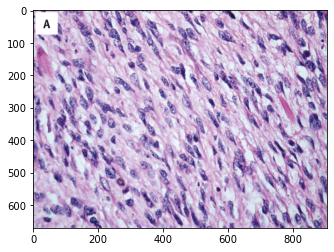

f12c8088-05a5-41a6-80b8-aa4cfa461236


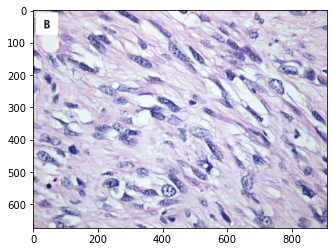

In [27]:
test_instance = arch_books_dataset.__getitem__(0)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

 Chondroblastoma demonstrates sheets of round to ovoid cells admixed with osteoclast-like giant cells. the delicate pericellular calcification of the matrix has been described as chicken wire. 

Total images: 1 

6fd98e2d-14ca-44ef-b064-1dfa11a9a8b1


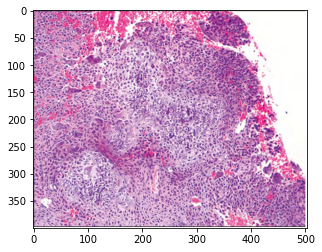

In [28]:
test_instance = arch_books_dataset.__getitem__(5)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

 A, A cytologically bland spindle cell proliferation set in a myxoid background and associated with a distinctive plexiform capillary network represents the histologic hallmark of pure myxoid liposarcoma. B, In myxoid and round cell liposarcoma, pure myxoid liposarcoma hypercellular foci begin to form around blood vessels. C, In high-grade “round cell” liposarcoma, adipocytic differentiation can be minimal. 

Total images: 3 

6e0d999d-c149-4714-9b0e-db9a67cb05ed


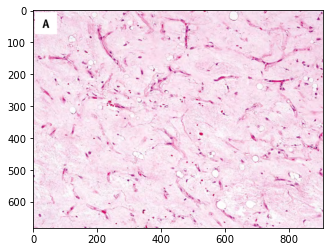

62446674-4f6e-444c-878f-be2265de1310


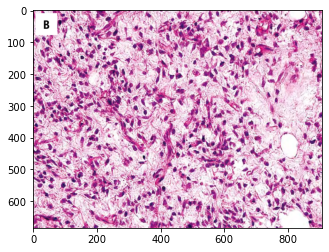

0718096a-6563-49af-a83a-030836b210d4


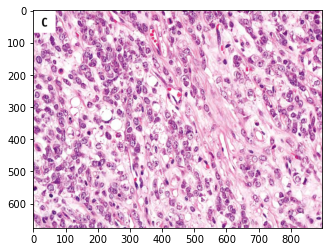

In [29]:
test_instance = arch_books_dataset.__getitem__(18)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

## Unified Dataset Class for ARCH Dataset

In [62]:
class ArchCaptionsDatasetRaw(Dataset):
    r"""
    A PyTorch dataset to read ARCH dataset and provide it completely
    unprocessed. This dataset is used by various task-specific datasets
    in :mod:`~virtex.data.datasets` module.

    Args:
        data_root: Path to the ARCH dataset root directory.
        source: Name of ARCH source to read. One of ``{"pubmed", "books"}``.
        split:  Name of ARCH split to read. One of ``{"train", "val"}``.
    """

    def __init__(self, data_root: str, source: str, split: str=''):
        assert source in ['pubmed', 'books'], "source should be one of ['pubmed', 'books']"
        assert split in ['train', 'val', ''], "split should be one of ['train', 'val', '']"

#         TODO: change after splitting the caption files into train and validation
#         
#         # Get paths to image directory and annotation file.
#         image_dir = os.path.join(data_root, "pubmed_set/images", f"{split}")
#         captions = json.load(
#             open(os.path.join(data_root, "pubmed_set", f"captions_{split}.json"))
#         )
            
        # Get path to image directory and record the extensions
        image_dir = os.path.join(data_root, f"{source}_set", "images")
        uuids_to_extensions = {
            file_name.split('.')[0]: file_name.split('.')[1]
            for file_name in os.listdir(image_dir)
        }
        
        # Get path to the annotation file
        captions = json.load(
            open(os.path.join(data_root, f"{source}_set", "captions.json"))
        )
        
        # Collect list of uuids and file paths for each caption
        captions_to_uuids: Dict[str, List[str]] = defaultdict(list)
        captions_to_image_filepaths: Dict[str, List[str]] = defaultdict(list)
        for idx, ann in captions.items():
            if ann['uuid'] in uuids_to_extensions.keys():
                # uuids_to_extensions contains only image uuids from the image dir
                # this means that only uuids with exisitng images will be added
                captions_to_uuids[ann['caption']].append(ann['uuid'])
                captions_to_image_filepaths[ann['caption']].append(
                    os.path.join(image_dir, f"{ann['uuid']}.{uuids_to_extensions[ann['uuid']]}")
                )
        #print(captions_per_image)

        # Keep all annotations in memory. Make a list of tuples, each tuple
        # is ``(list[image_id], list[file_path], captions)``.
        self.instances = [
            (captions_to_uuids[caption], captions_to_image_filepaths[caption], caption)
            for caption in captions_to_image_filepaths.keys()
        ]

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx: int):
        image_ids, image_paths, caption = self.instances[idx]

        # shape: (height, width, channels), dtype: uint8
        images = [cv2.imread(image_path) for image_path in image_paths]
        # cv2.imread loads images in BGR (blue, green, red) order
        images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

        return {"image_ids": image_ids, "images": images, "caption": caption}

In [63]:
#help(ArchCaptionsDatasetRaw)

In [64]:
arch_books_dataset = ArchCaptionsDatasetRaw(data_root='../datasets/ARCH',
                                         source="books")
arch_books_dataset.instances

[(['890e2e79-ab0a-4a2e-9d62-b0b6b3d43884',
   'f12c8088-05a5-41a6-80b8-aa4cfa461236'],
  ['../datasets/ARCH/books_set/images/890e2e79-ab0a-4a2e-9d62-b0b6b3d43884.png',
   '../datasets/ARCH/books_set/images/f12c8088-05a5-41a6-80b8-aa4cfa461236.png'],
  ' A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma.'),
 (['9a77b172-74e8-4e64-878f-d26b7c27239f'],
  ['../datasets/ARCH/books_set/images/9a77b172-74e8-4e64-878f-d26b7c27239f.png'],
  ' In the anaplastic variant of embryonal rhabdomyosarcoma, the tumor cells have enlarged hyperchromatic and atypical nuclei. Note the presence of a tripolar mitotic figure.'),
 (['c384e7fc-7b29-4a72-a8b2-0f4f8ff9d536',
   'd8f9e62e-e400-43c7-8202-b5c4033710ba'],
  ['../datasets/ARCH/books_set/images/c384e7fc-7b29-4a72-a8b2-0f4f8ff9d536.png',
   '../datasets/ARCH/books_set/images/d8f9e62e-e400-43c7-8202-b5c

 A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma. 

Total images: 2 

890e2e79-ab0a-4a2e-9d62-b0b6b3d43884


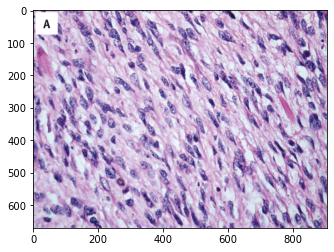

f12c8088-05a5-41a6-80b8-aa4cfa461236


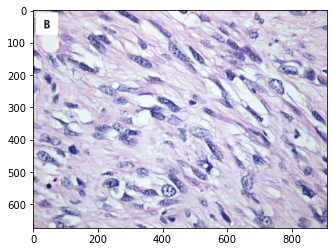

In [65]:
test_instance = arch_books_dataset.__getitem__(0)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

In [66]:
arch_pubmed_dataset = ArchCaptionsDatasetRaw(data_root='../datasets/ARCH',
                                          source="pubmed")
arch_pubmed_dataset.instances

[(['3f93c716-8fc9-42e9-bc29-bec52a51ab4b'],
  ['../datasets/ARCH/pubmed_set/images/3f93c716-8fc9-42e9-bc29-bec52a51ab4b.jpg'],
  'ER expression in tumor tissue. IHC staining, original'),
 (['9fcdf1e1-139c-4b63-bf1a-79d83c71f41a'],
  ['../datasets/ARCH/pubmed_set/images/9fcdf1e1-139c-4b63-bf1a-79d83c71f41a.jpg'],
  'Nuclear expression of TS (brown) in a colon carcinoma'),
 (['00f1ad7a-f4b0-4938-b874-089d40a123ce'],
  ['../datasets/ARCH/pubmed_set/images/00f1ad7a-f4b0-4938-b874-089d40a123ce.jpg'],
  'Nuclear expression of E2F1 (brown) in a colon carcinoma. This is higher magnification of the upper portion of a core shown in an inset (lower left corner)'),
 (['9d3aef30-7c8b-4b78-9acf-ec523f952650'],
  ['../datasets/ARCH/pubmed_set/images/9d3aef30-7c8b-4b78-9acf-ec523f952650.jpg'],
  'Cytoplasmic immunoexpression of PD-L1 in oral squamous cell carcinomas with poorer prognosis (OSCCPP). Immunohistochemistry. Total magnification x100'),
 (['b317d529-3626-49fc-9282-e4f28cf3d1cb'],
  ['../data

Low-grade peritoneal serous carcinoma. Monomorphic cells associated with psammoma bodies are seen. Hematoxylin and eosin stain, original magnification: x100. 

Total images: 3 

8764ba9f-d248-4d12-b9dd-4d8d6a28a9de


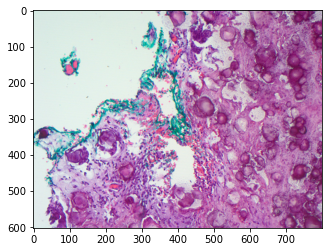

fb650184-e406-4fc5-9a41-c8940c05d6a7


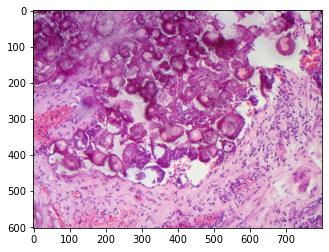

2b9426a9-f26c-436e-8b41-da3bdf1b6fe1


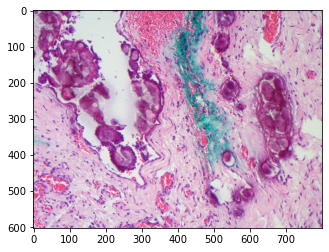

In [67]:
test_instance = arch_pubmed_dataset.__getitem__(19)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

In [68]:
help(ArchCaptionsDatasetRaw)

Help on class ArchCaptionsDatasetRaw in module __main__:

class ArchCaptionsDatasetRaw(torch.utils.data.dataset.Dataset)
 |  ArchCaptionsDatasetRaw(*args, **kwds)
 |  
 |  A PyTorch dataset to read ARCH dataset and provide it completely
 |  unprocessed. This dataset is used by various task-specific datasets
 |  in :mod:`~virtex.data.datasets` module.
 |  
 |  Args:
 |      data_root: Path to the ARCH dataset root directory.
 |      source: Name of ARCH source to read. One of ``{"pubmed", "books"}``.
 |      split:  Name of ARCH split to read. One of ``{"train", "val"}``.
 |  
 |  Method resolution order:
 |      ArchCaptionsDatasetRaw
 |      torch.utils.data.dataset.Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, idx: int)
 |  
 |  __init__(self, data_root: str, source: str, split: str = '')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------

In [46]:
len(arch_pubmed_dataset)

3285

In [50]:
len(arch_books_dataset)

3210

## Make one dataset instance

In [69]:
arch_dataset = arch_books_dataset.__add__(arch_pubmed_dataset)
len(arch_dataset)

6495

 A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma. 

Total images: 2 

890e2e79-ab0a-4a2e-9d62-b0b6b3d43884


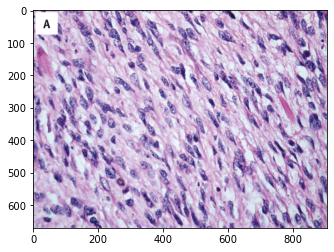

f12c8088-05a5-41a6-80b8-aa4cfa461236


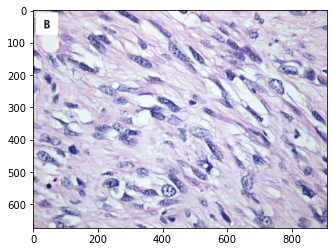

In [70]:
test_instance = arch_dataset.__getitem__(0) # same as the 0th example in the books dataset

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

Low-grade peritoneal serous carcinoma. Monomorphic cells associated with psammoma bodies are seen. Hematoxylin and eosin stain, original magnification: x100. 

Total images: 3 

8764ba9f-d248-4d12-b9dd-4d8d6a28a9de


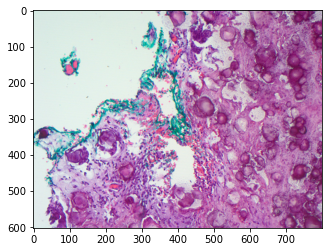

fb650184-e406-4fc5-9a41-c8940c05d6a7


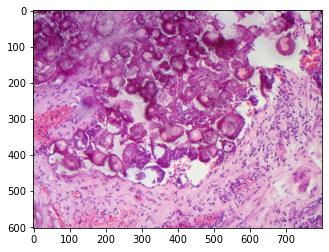

2b9426a9-f26c-436e-8b41-da3bdf1b6fe1


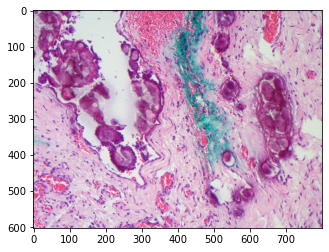

In [71]:
# same as the 19th example in the pubmed dataset 
# there are 3210 examples in the books set
# pubmed set is concatenated to it -> 3239 gives the 19th example in the pubmed set
test_instance = arch_dataset.__getitem__(3229)

print(test_instance['caption'], '\n')
print("Total images:", len(test_instance['images']), '\n')

for i, img_id in enumerate(test_instance['image_ids']):
    print(img_id)
    img=test_instance['images'][i]
    plt.imshow(img)
    plt.show()

## Make one file with all annotations